# 2017 Medicare Charged Amounts
## Top 5 Procedures at Top 50 Providers in all 50 States and D.C.
### Anne Bode

### <font color=blue>1.  Importing & preparing the data </font>
Data has been obtained from the CMS: https://data.cms.gov/Medicare-Physician-Supplier/Medicare-Provider-Utilization-and-Payment-Data-Phy/fs4p-t5eq

We now import the data, drop superfluous columns, and remove all providers who do not practice in the 50 states + D.C.

We then calculate the 50 most common provider types, and each provider type's top 5 most common procedures. Note, we must remove the provider types who do not have any billed procedures in this dataset.

In [314]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import folium

%matplotlib inline

#### <font color=orange>A. Medicare 2017 Claims Data: Import and Clean</font>

In [315]:
# import data into pandas dataframe
df_2017 = pd.read_table('Medicare_Provider_Util_Payment_PUF_CY2017.txt')
df_2017.head()

C:\Users\abode\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,npi,nppes_provider_last_org_name,nppes_provider_first_name,nppes_provider_mi,nppes_credentials,nppes_provider_gender,nppes_entity_code,nppes_provider_street1,nppes_provider_street2,nppes_provider_city,...,hcpcs_code,hcpcs_description,hcpcs_drug_indicator,line_srvc_cnt,bene_unique_cnt,bene_day_srvc_cnt,average_Medicare_allowed_amt,average_submitted_chrg_amt,average_Medicare_payment_amt,average_Medicare_standard_amt
0,1,CPT copyright 2016 American Medical Associatio...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1003000126,ENKESHAFI,ARDALAN,NaN,M.D.,M,I,900 SETON DR,NaN,CUMBERLAND,...,99217,Hospital observation care discharge,N,100.0,96.0,100.0,73.398800,325.780000,56.827200,57.492400
2,1003000126,ENKESHAFI,ARDALAN,NaN,M.D.,M,I,900 SETON DR,NaN,CUMBERLAND,...,99218,Hospital observation care typically 30 minutes,N,26.0,25.0,26.0,100.080000,449.000000,78.460000,79.306154
3,1003000126,ENKESHAFI,ARDALAN,NaN,M.D.,M,I,900 SETON DR,NaN,CUMBERLAND,...,99219,Hospital observation care typically 50 minutes,N,52.0,51.0,52.0,136.380000,614.000000,102.807692,103.895385
4,1003000126,ENKESHAFI,ARDALAN,NaN,M.D.,M,I,900 SETON DR,NaN,CUMBERLAND,...,99220,Hospital observation care typically 70 minutes...,N,59.0,59.0,59.0,190.363729,755.932203,141.293559,142.865763


In [316]:
# clean up dataframe

# drop unneccesary columns as well as non-US providers
df2 = df_2017.drop(['nppes_provider_mi',
               'nppes_credentials',
               'nppes_entity_code',
               'nppes_provider_street1',
               'nppes_provider_street2',
               'medicare_participation_indicator',
               'line_srvc_cnt',
               'bene_unique_cnt',
               'bene_day_srvc_cnt'
              ], axis=1)
df2.drop(df2.loc[df2['nppes_provider_country'] != 'US'].index, inplace=True)
df2.dropna(inplace=True)

# drop the armed forces and territories
Non_States = ['VI','GU','ZZ','AE','AP','MP','XX','AA','AS','PR']
df2 = df2[~df2['nppes_provider_state'].isin(Non_States)]

# remove provider types that provide no billable services in dataset
No_Services = ['Mass Immunizer Roster Biller', 'Clinical Laboratory', 'Ambulatory Surgical Center', 'Centralized Flu']
df2 = df2[~df2['provider_type'].isin(No_Services)]

# rename nppes_provider_state to just "state"
df2.rename(columns={"nppes_provider_state": "state"}, inplace=True)

In [317]:
# get top 50 provider types that provide services
providerseries = df2['provider_type'].value_counts().head(50)
providerlist = providerseries.index.tolist()
print(providerlist)

# reduce table down to just include these provider types
df2 = df2[df2['provider_type'].isin(providerlist)]

['Diagnostic Radiology', 'Internal Medicine', 'Family Practice', 'Nurse Practitioner', 'Cardiology', 'Physician Assistant', 'Orthopedic Surgery', 'Physical Therapist in Private Practice', 'Ophthalmology', 'Anesthesiology', 'Emergency Medicine', 'Dermatology', 'Podiatry', 'Urology', 'Gastroenterology', 'Hematology-Oncology', 'Optometry', 'General Surgery', 'Pathology', 'Pulmonary Disease', 'Neurology', 'Certified Registered Nurse Anesthetist (CRNA)', 'Nephrology', 'Obstetrics & Gynecology', 'Otolaryngology', 'Physical Medicine and Rehabilitation', 'Psychiatry', 'Radiation Oncology', 'Interventional Cardiology', 'Rheumatology', 'Vascular Surgery', 'Clinical Cardiac Electrophysiology', 'Endocrinology', 'Medical Oncology', 'Chiropractic', 'Interventional Radiology', 'Neurosurgery', 'General Practice', 'Infectious Disease', 'Pain Management', 'Psychologist, Clinical', 'Interventional Pain Management', 'Hospitalist', 'Licensed Clinical Social Worker', 'Allergy/ Immunology', 'Critical Care (I

In [318]:
# for each of the top 50 providers, remove all rows that are not for one of their top 5 services
for p in providerlist:
    temp_df = df2[df2['provider_type'] == p]
    hcpcsseries = temp_df['hcpcs_code'].value_counts().head(5)
    hcpcslist = hcpcsseries.index.tolist()
    if hcpcslist == []:
        print(p)
    df2.drop(df2.loc[(df2['provider_type'] == p) & ~df2['hcpcs_code'].isin(hcpcslist)].index, inplace=True)

df2.head()

,npi,nppes_provider_last_org_name,nppes_provider_first_name,nppes_provider_gender,nppes_provider_city,nppes_provider_zip,state,nppes_provider_country,provider_type,place_of_service,hcpcs_code,hcpcs_description,hcpcs_drug_indicator,average_Medicare_allowed_amt,average_submitted_chrg_amt,average_Medicare_payment_amt,average_Medicare_standard_amt
7,1003000126,ENKESHAFI,ARDALAN,M,CUMBERLAND,2.15022e+08,MD,US,Internal Medicine,F,99223,"Initial hospital inpatient care, typically 70 ...",N,206.061579,923.991228,160.377193,160.026316
8,1003000126,ENKESHAFI,ARDALAN,M,CUMBERLAND,2.15022e+08,MD,US,Internal Medicine,F,99232,"Subsequent hospital inpatient care, typically ...",N,72.622456,326.245614,56.366730,57.047895
9,1003000126,ENKESHAFI,ARDALAN,M,CUMBERLAND,2.15022e+08,MD,US,Internal Medicine,F,99233,"Subsequent hospital inpatient care, typically ...",N,106.653913,461.072464,82.820676,83.196039
12,1003000134,CIBULL,THOMAS,M,EVANSTON,6.02012e+08,IL,US,Pathology,F,88304,Pathology examination of tissue using a micros...,N,12.789739,115.000000,9.842127,9.390821
13,1003000134,CIBULL,THOMAS,M,EVANSTON,6.02012e+08,IL,US,Pathology,F,88305,Pathology examination of tissue using a micros...,N,41.299942,170.000000,31.426415,30.401900


#### <font color=orange>B. 2017 State Median Income Data: Import and Clean</font>
Data obtained from US census: https://www2.census.gov/programs-surveys/cps/tables/time-series/historical-income-households/h08.xls

In [319]:
# import data, rename column to match Medicare dataset
med_income_df = pd.read_csv("2017 Median Income.csv")
med_income_df.rename(columns={"State Code": "state"}, inplace=True)
med_income_df.head()

,state,2017 Median Income
0,US,62868
1,AL,52359
2,AK,73992
3,AZ,62615
4,AR,50019


In [320]:
# obtain national median income, for reference
nat_med_2017 = med_income_df.iloc[0,1]
nat_med_2017

62868

In [321]:
# calculate multiplier for each state; national median income / state's median income
# this will be used to adjust the submitted charge amounts so that difference in income is taken into account
med_income_df['Med_Multiplier'] = nat_med_2017 / med_income_df['2017 Median Income']
med_income_df.head()

,state,2017 Median Income,Med_Multiplier
0,US,62868,1.000000
1,AL,52359,1.200710
2,AK,73992,0.849659
3,AZ,62615,1.004041
4,AR,50019,1.256882


#### <font color=orange>C. 2017 State Population Data: Import and Clean</font>
Data obtained from US Census: https://www.census.gov/data/tables/time-series/demo/popest/2010s-state-total.html

In [322]:
# import data from CSV (copy/pasted with Medicare column titles)
population_df = pd.read_csv("2017 US Population.csv")
population_df.head()

,state,2017 Population
0,US,324985539
1,AL,4874486
2,AK,739700
3,AZ,7044008
4,AR,3001345


In [323]:
# obtain national population, for reference
nat_population = population_df.iloc[0,1]
nat_population

324985539

### <font color=blue>2. Calculating the Mean & Median Medicare Claims</font>

We now calculate the Mean and Median medicare claims submitted by:  
A. Provider & HCPCS (Procedure) Description (i.e. Cardiologist Heart Transplant mean cost is 10,000 dollars)  
B. State & Provider & HCPCS (Procedure) Description (i.e. Cardiologist Heart Transplant in New York mean cost is 15,000 dollars)  
C. State (i.e. New York mean procedure cost is 300 dollars)  

Note that our state mean/median is based off of the means/medians calculated in item #2 on the list, so that each procedure and each provider is equally weighted in the calculation


In [324]:
# reduce dataframe to state, provider type, hcpcs description, and average submitted charge for that hcpcs description
hcpcs_df = df2[['state','provider_type','hcpcs_code','hcpcs_description','average_submitted_chrg_amt']]

# now add median multiplier per state as a column in the Provider/HCPCS dataframe
hcpcs_df = pd.merge(hcpcs_df,
                    med_income_df[['state','Med_Multiplier']],
                    on=['state'])

# calculate the "adjusted" submitted charge, add as new column
hcpcs_df['ADJ_submitted_chrg_amt'] = hcpcs_df['average_submitted_chrg_amt']*hcpcs_df['Med_Multiplier']

hcpcs_df.head()

,state,provider_type,hcpcs_code,hcpcs_description,average_submitted_chrg_amt,Med_Multiplier,ADJ_submitted_chrg_amt
0,MD,Internal Medicine,99223,"Initial hospital inpatient care, typically 70 ...",923.991228,0.75689,699.359272
1,MD,Internal Medicine,99232,"Subsequent hospital inpatient care, typically ...",326.245614,0.75689,246.931885
2,MD,Internal Medicine,99233,"Subsequent hospital inpatient care, typically ...",461.072464,0.75689,348.980913
3,MD,Internal Medicine,99223,"Initial hospital inpatient care, typically 70 ...",417.000000,0.75689,315.622928
4,MD,Internal Medicine,99232,"Subsequent hospital inpatient care, typically ...",148.000000,0.75689,112.019648


#### <font color=orange>A. NATIONAL HCPCS MEAN & MEDIAN</font>
i.e. Cardiologist Heart Transplant mean cost is 10,000 and median cost is 7,500

In [325]:
# take unadj. average by hcpcs description & provider
hcpcs_df_avg = hcpcs_df[['provider_type','hcpcs_code','hcpcs_description','average_submitted_chrg_amt']].groupby(['provider_type','hcpcs_code']).mean()
hcpcs_df_avg.rename(columns={"average_submitted_chrg_amt": "NAT_avg_submitted"},
                    inplace=True)

# take unadj. median by hcpcs description & provider
hcpcs_df_med = hcpcs_df[['provider_type','hcpcs_code','hcpcs_description','average_submitted_chrg_amt']].groupby(['provider_type','hcpcs_code']).median()
hcpcs_df_med.rename(columns={"average_submitted_chrg_amt": "NAT_med_submitted"},
                    inplace=True)

#-----------------------------------------------------------------------------------------------------------------

# take adj. average by hcpcs description & provider
hcpcs_df_avg_ADJ = hcpcs_df[['provider_type','hcpcs_code','hcpcs_description','ADJ_submitted_chrg_amt']].groupby(['provider_type','hcpcs_code']).mean()
hcpcs_df_avg_ADJ.rename(columns={"ADJ_submitted_chrg_amt": "ADJ_NAT_avg_submitted"},
                    inplace=True)

# take adj. median by hcpcs description & provider
hcpcs_df_med_ADJ = hcpcs_df[['provider_type','hcpcs_code','hcpcs_description','ADJ_submitted_chrg_amt']].groupby(['provider_type','hcpcs_code']).median()
hcpcs_df_med_ADJ.rename(columns={"ADJ_submitted_chrg_amt": "ADJ_NAT_med_submitted"},
                    inplace=True)

#-----------------------------------------------------------------------------------------------------------------

# merge dataframes and flatten table out
nat_hcpcs_df = pd.merge(hcpcs_df_avg, hcpcs_df_med, on=['provider_type','hcpcs_code'])
nat_hcpcs_df = pd.merge(nat_hcpcs_df, hcpcs_df_avg_ADJ, on=['provider_type','hcpcs_code'])
nat_hcpcs_df = pd.merge(nat_hcpcs_df, hcpcs_df_med_ADJ, on=['provider_type','hcpcs_code'])
nat_hcpcs_df.reset_index(inplace=True)

nat_hcpcs_df.head()

,provider_type,hcpcs_code,NAT_avg_submitted,NAT_med_submitted,ADJ_NAT_avg_submitted,ADJ_NAT_med_submitted
0,Allergy/ Immunology,95004,12.619427,11.000000,12.403008,11.231609
1,Allergy/ Immunology,95117,33.692280,32.000000,33.276428,32.296507
2,Allergy/ Immunology,99204,288.425813,260.000000,284.166826,259.812830
3,Allergy/ Immunology,99213,124.571406,113.858077,122.669402,114.326241
4,Allergy/ Immunology,99214,184.616495,165.000000,180.732863,165.605532


#### <font color=orange>B. STATE HCPCS MEAN & MEDIAN  </font>
i.e. Cardiologist Heart Transplant in New York mean cost is 15,000 and median cost is $12,500  

- Adjust for state median income vs. national median income, to calculate the adjusted cost per claim  
- Then also incorporate number of providers offering a service/procedure (hcpcs description) in a given state  
- Also calculate number of people in the state per providers offering that service/procedure, using 2017 population data  

In [326]:
# take unadj. average by state & hcpcs description & provider
state_hcpcs_df_avg = hcpcs_df[['state','provider_type','hcpcs_code','hcpcs_description','average_submitted_chrg_amt']].groupby(['state','provider_type','hcpcs_code']).mean()
state_hcpcs_df_avg.rename(columns={"average_submitted_chrg_amt": "STATE_HCPCS_avg_submitted"},
                  inplace=True)

# take unadj. median by state & hcpcs description & provider
state_hcpcs_df_med = hcpcs_df[['state','provider_type','hcpcs_code','hcpcs_description','average_submitted_chrg_amt']].groupby(['state','provider_type','hcpcs_code']).median()
state_hcpcs_df_med.rename(columns={"average_submitted_chrg_amt": "STATE_HCPCS_med_submitted"},
                  inplace=True)

#-----------------------------------------------------------------------------------------------------------------

# take adj. average by state & hcpcs description & provider
state_hcpcs_df_avg_ADJ = hcpcs_df[['state','provider_type','hcpcs_code','hcpcs_description','ADJ_submitted_chrg_amt']].groupby(['state','provider_type','hcpcs_code']).mean()
state_hcpcs_df_avg_ADJ.rename(columns={"ADJ_submitted_chrg_amt": "ADJ_STATE_HCPCS_avg_submitted"},
                  inplace=True)

# take adj. median by state & hcpcs description & provider
state_hcpcs_df_med_ADJ = hcpcs_df[['state','provider_type','hcpcs_code','hcpcs_description','ADJ_submitted_chrg_amt']].groupby(['state','provider_type','hcpcs_code']).median()
state_hcpcs_df_med_ADJ.rename(columns={"ADJ_submitted_chrg_amt": "ADJ_STATE_HCPCS_med_submitted"},
                  inplace=True)

#-----------------------------------------------------------------------------------------------------------------

# merge dataframes and flatten table out
state_hcpcs_df = pd.merge(state_hcpcs_df_avg, state_hcpcs_df_med, on=['state','provider_type','hcpcs_code'])
state_hcpcs_df = pd.merge(state_hcpcs_df, state_hcpcs_df_avg_ADJ, on=['state','provider_type','hcpcs_code'])
state_hcpcs_df = pd.merge(state_hcpcs_df, state_hcpcs_df_med_ADJ, on=['state','provider_type','hcpcs_code'])
state_hcpcs_df.reset_index(inplace=True)

#-----------------------------------------------------------------------------------------------------------------

# add number of providers per service per state
# pull just provider ID, state, type, and hcpcs description to find out how many providers offer a procedure/service in a given state
prov_per_state = df2[['npi','state', 'provider_type', 'hcpcs_code']].drop_duplicates()
prov_per_state = prov_per_state.groupby(['state','provider_type','hcpcs_code']).count()
prov_per_state.reset_index(inplace=True)
prov_per_state.rename(columns={'npi':'Num Providers'},inplace=True)

state_hcpcs_df = pd.merge(state_hcpcs_df,
                          prov_per_state,
                          on=['state','provider_type','hcpcs_code'])

#-----------------------------------------------------------------------------------------------------------------

# add state population to the dataframe
# use this to calculate people per provider of each hcpcs description (service)
state_hcpcs_df = pd.merge(state_hcpcs_df,
                          population_df,
                          on=['state'])

# calculate people per provider per procedure/service (hcpcs description)
state_hcpcs_df['People Per Provider'] = state_hcpcs_df['2017 Population'] / state_hcpcs_df['Num Providers']

state_hcpcs_df.head()

,state,provider_type,hcpcs_code,STATE_HCPCS_avg_submitted,STATE_HCPCS_med_submitted,ADJ_STATE_HCPCS_avg_submitted,ADJ_STATE_HCPCS_med_submitted,Num Providers,2017 Population,People Per Provider
0,AK,Allergy/ Immunology,95004,15.835184,16.0,13.454513,13.594551,6,739700,123283.333333
1,AK,Allergy/ Immunology,95117,40.000000,40.0,33.986377,33.986377,1,739700,739700.000000
2,AK,Allergy/ Immunology,99204,411.370879,407.0,349.525144,345.811385,6,739700,123283.333333
3,AK,Allergy/ Immunology,99213,185.469867,180.0,157.586220,152.938696,8,739700,92462.500000
4,AK,Allergy/ Immunology,99214,271.335714,265.0,230.542946,225.159747,7,739700,105671.428571


#### <font color=orange>C. STATE MEAN & MEDIAN  </font>
i.e. New York mean procedure cost is 300 and median is 250  
  
<font color=red>note: we use the Mean per Provider & HCPCS Description within the state, calculated above; we then calculate the Mean and Median of these Means, below. This way, each Provider & HCPCS Description is weighted equally</font>

In [327]:
# average price per state, using average provider/hcpcs price across state
state_df_avg = state_hcpcs_df_avg.groupby(['state']).mean()
state_df_avg.rename(columns={"STATE_HCPCS_avg_submitted": "STATE_avg_submitted"},
                  inplace=True)

# median price per state, using average provider/hcpcs price across state
state_df_med = state_hcpcs_df_avg.groupby(['state']).median()
state_df_med.rename(columns={"STATE_HCPCS_avg_submitted": "STATE_med_submitted"},
                  inplace=True)

# merge the two dataframes above
state_df = pd.merge(state_df_avg, state_df_med, on=['state'])
state_df.reset_index(inplace=True)

# then add the state's median income, by merging with income dataframe
state_df = pd.merge(state_df, med_income_df, on=['state'])

# calculated adjusted average and median by multiplying by median multiplier for each state
state_df['ADJ_STATE_avg_submitted'] = state_df['STATE_avg_submitted'] * state_df['Med_Multiplier']
state_df['ADJ_STATE_med_submitted'] = state_df['STATE_med_submitted'] * state_df['Med_Multiplier']

state_df.head()

,state,STATE_avg_submitted,STATE_med_submitted,2017 Median Income,Med_Multiplier,ADJ_STATE_avg_submitted,ADJ_STATE_med_submitted
0,AK,558.192173,297.493966,73992,0.849659,474.273240,252.768552
1,AL,224.142575,145.227778,52359,1.200710,269.130339,174.376515
2,AR,240.630251,164.496608,50019,1.256882,302.443923,206.752889
3,AZ,274.363994,188.153732,62615,1.004041,275.472580,188.913980
4,CA,316.515219,219.077871,71459,0.879777,278.462878,192.739719


### <font color=blue>3. Calculating Differences from National Mean/Median</font>

Here we take the means and medians we calculated for each Provider & HCPCS Description & State, and we compare them to the means and medians we calculated nationally for each Provider & HCPCS Description

i.e. we can find out that the Mean price of a Cardiologist's Heart Transplant in New York is 50% higher than the National Mean; similarly can be calculated for Median!

We can THEN calculate the average difference across all Providers/HCPCS per state and add to the State dataframe (state_df_fin)

A. Mean Provider/HCPCS Claim vs. National Mean & average difference  
B. Median Provider/HCPCS Claim vs. National Median & average difference

#### <font color=orange>A. State Mean vs National Mean</font>
PLUS Adjustments for Median Income

In [328]:
# merge the state/provider/hcpcs dataframe with the national provider/hcpcs dataframe, to compare state values to national
avg_comparison_df = pd.merge(state_hcpcs_df, nat_hcpcs_df, on=['provider_type','hcpcs_code'])

# calculate the difference in state mean vs. national mean
avg_comparison_df['avg_difference_charged'] = (avg_comparison_df['STATE_HCPCS_avg_submitted'] - avg_comparison_df['NAT_avg_submitted']) / avg_comparison_df['NAT_avg_submitted']

# take the average of all of these differences
avg_by_state = avg_comparison_df.groupby(['state'])['avg_difference_charged'].mean().reset_index()

# repeat for adjusted state mean vs. adjusted national mean
avg_comparison_df['ADJ_avg_difference_charged'] = (avg_comparison_df['ADJ_STATE_HCPCS_avg_submitted'] - avg_comparison_df['ADJ_NAT_avg_submitted']) / avg_comparison_df['ADJ_NAT_avg_submitted']
ADJ_avg_by_state = avg_comparison_df.groupby(['state'])['ADJ_avg_difference_charged'].mean().reset_index()

# add both to state_df_fin
state_df = pd.merge(state_df, avg_by_state, on=['state'])
state_df = pd.merge(state_df, ADJ_avg_by_state, on=['state'])

#### <font color=orange>B. State Median vs. National Median</font>
PLUS Adjustments for Median Income

In [329]:
# merge the state/provider/hcpcs dataframe with the national provider/hcpcs dataframe, to compare state values to national
med_comparison_df = pd.merge(state_hcpcs_df, nat_hcpcs_df, on=['provider_type','hcpcs_code'])

# calculate the difference in state median vs. national median
med_comparison_df['med_difference_charged'] = (med_comparison_df['STATE_HCPCS_med_submitted'] - med_comparison_df['NAT_med_submitted']) / med_comparison_df['NAT_med_submitted']

# take the average of all of these differences
med_by_state = med_comparison_df.groupby(['state'])['med_difference_charged'].mean().reset_index()

# repeat for adjusted state median vs. adjusted national median
med_comparison_df['ADJ_med_difference_charged'] = (med_comparison_df['ADJ_STATE_HCPCS_med_submitted'] - med_comparison_df['ADJ_NAT_med_submitted']) / med_comparison_df['ADJ_NAT_med_submitted']
ADJ_med_by_state = med_comparison_df.groupby(['state'])['ADJ_med_difference_charged'].mean().reset_index()

# add to state_df_fin
state_df = pd.merge(state_df, med_by_state, on=['state'])
state_df = pd.merge(state_df, ADJ_med_by_state, on=['state'])

state_df.head()

,state,STATE_avg_submitted,STATE_med_submitted,2017 Median Income,Med_Multiplier,ADJ_STATE_avg_submitted,ADJ_STATE_med_submitted,avg_difference_charged,ADJ_avg_difference_charged,med_difference_charged,ADJ_med_difference_charged
0,AK,558.192173,297.493966,73992,0.849659,474.273240,252.768552,0.710083,0.454965,0.935846,0.640220
1,AL,224.142575,145.227778,52359,1.200710,269.130339,174.376515,-0.235205,-0.079725,-0.211856,-0.053364
2,AR,240.630251,164.496608,50019,1.256882,302.443923,206.752889,-0.166147,0.050513,-0.122951,0.102995
3,AZ,274.363994,188.153732,62615,1.004041,275.472580,188.913980,-0.071909,-0.066402,-0.019472,-0.015721
4,CA,316.515219,219.077871,71459,0.879777,278.462878,192.739719,0.101236,-0.028902,0.093493,-0.038716


### <font color=blue>4. Visualizing the Data</font>

A. State Ranks by Category (Mean Price, Median Price, Mean Diff from National Mean, Mean Diff from National Median)  
B. State Mean Price + Mean Diff from National Mean  
C. State Median Price + Mean Diff from National Median  
D. Chloropleth maps to visualise the four categories discussed above

#### <font color=orange>A. State Ranks by Category</font>

In [330]:
# copy state dataframe so we can create a rank df
state_df_ranks = state_df.copy()

In [331]:
#sort the state dataframe and insert ranking for each category
state_df_ranks.sort_values('ADJ_med_difference_charged', ascending=False, inplace=True)
state_df_ranks.insert(0, 'ADJ_State_Med_Diff_Rank', range(1, 52))

state_df_ranks.sort_values('ADJ_avg_difference_charged', ascending=False, inplace=True)
state_df_ranks.insert(0, 'ADJ_State_Avg_Diff_Rank', range(1, 52))

state_df_ranks.sort_values('med_difference_charged', ascending=False, inplace=True)
state_df_ranks.insert(0, 'State_Med_Diff_Rank', range(1, 52))

state_df_ranks.sort_values('avg_difference_charged', ascending=False, inplace=True)
state_df_ranks.insert(0, 'State_Avg_Diff_Rank', range(1, 52))

state_df_ranks.sort_values('ADJ_STATE_med_submitted', ascending=False, inplace=True)
state_df_ranks.insert(0, 'ADJ_State_Med_Rank', range(1, 52))

state_df_ranks.sort_values('ADJ_STATE_avg_submitted', ascending=False, inplace=True)
state_df_ranks.insert(0, 'ADJ_State_Avg_Rank', range(1, 52))

state_df_ranks.sort_values('STATE_med_submitted', ascending=False, inplace=True)
state_df_ranks.insert(0, 'State_Med_Rank', range(1, 52))

state_df_ranks.sort_values('STATE_avg_submitted', ascending=False, inplace=True)
state_df_ranks.insert(0, 'State_Avg_Rank', range(1, 52))
state_df_ranks.reset_index(drop=True, inplace=True)

state_df_ranks = state_df_ranks[['state',
                                 'State_Avg_Rank',
                                 'State_Med_Rank',
                                 'ADJ_State_Avg_Rank',
                                 'ADJ_State_Med_Rank',
                                 'State_Avg_Diff_Rank',
                                 'State_Med_Diff_Rank',
                                 'ADJ_State_Avg_Diff_Rank',
                                 'ADJ_State_Med_Diff_Rank']]

state_df_ranks.head()

,state,State_Avg_Rank,State_Med_Rank,ADJ_State_Avg_Rank,ADJ_State_Med_Rank,State_Avg_Diff_Rank,State_Med_Diff_Rank,ADJ_State_Avg_Diff_Rank,ADJ_State_Med_Diff_Rank
0,AK,1,1,1,1,1,1,1,1
1,WI,2,2,2,4,2,2,2,2
2,NJ,3,12,14,37,5,10,29,36
3,NY,4,3,7,5,3,6,9,13
4,NV,5,7,4,7,9,8,7,9


In [332]:
# visualize ranks in a color gradient table
state_df_ranks.sort_values('ADJ_State_Avg_Rank', inplace=True)
state_df_ranks.set_index('state', inplace=True)
cm = sns.diverging_palette(10, 240, n=9, as_cmap=True) 
state_df_ranks.style.background_gradient(cmap=cm)

,State_Avg_Rank,State_Med_Rank,ADJ_State_Avg_Rank,ADJ_State_Med_Rank,State_Avg_Diff_Rank,State_Med_Diff_Rank,ADJ_State_Avg_Diff_Rank,ADJ_State_Med_Diff_Rank
state,,,,,,,,
AK,1,1,1,1,1,1,1,1
WI,2,2,2,4,2,2,2,2
LA,19,35,3,2,32,32,3,3
NV,5,7,4,7,9,8,7,9
MS,36,45,5,8,39,39,4,4
WY,6,23,6,17,7,3,8,5
NY,4,3,7,5,3,6,9,13
FL,12,20,8,10,15,18,6,8
NC,22,28,9,9,26,24,10,7


#### <font color=orange>B. State Mean Price + Mean Diff from National Mean </font>

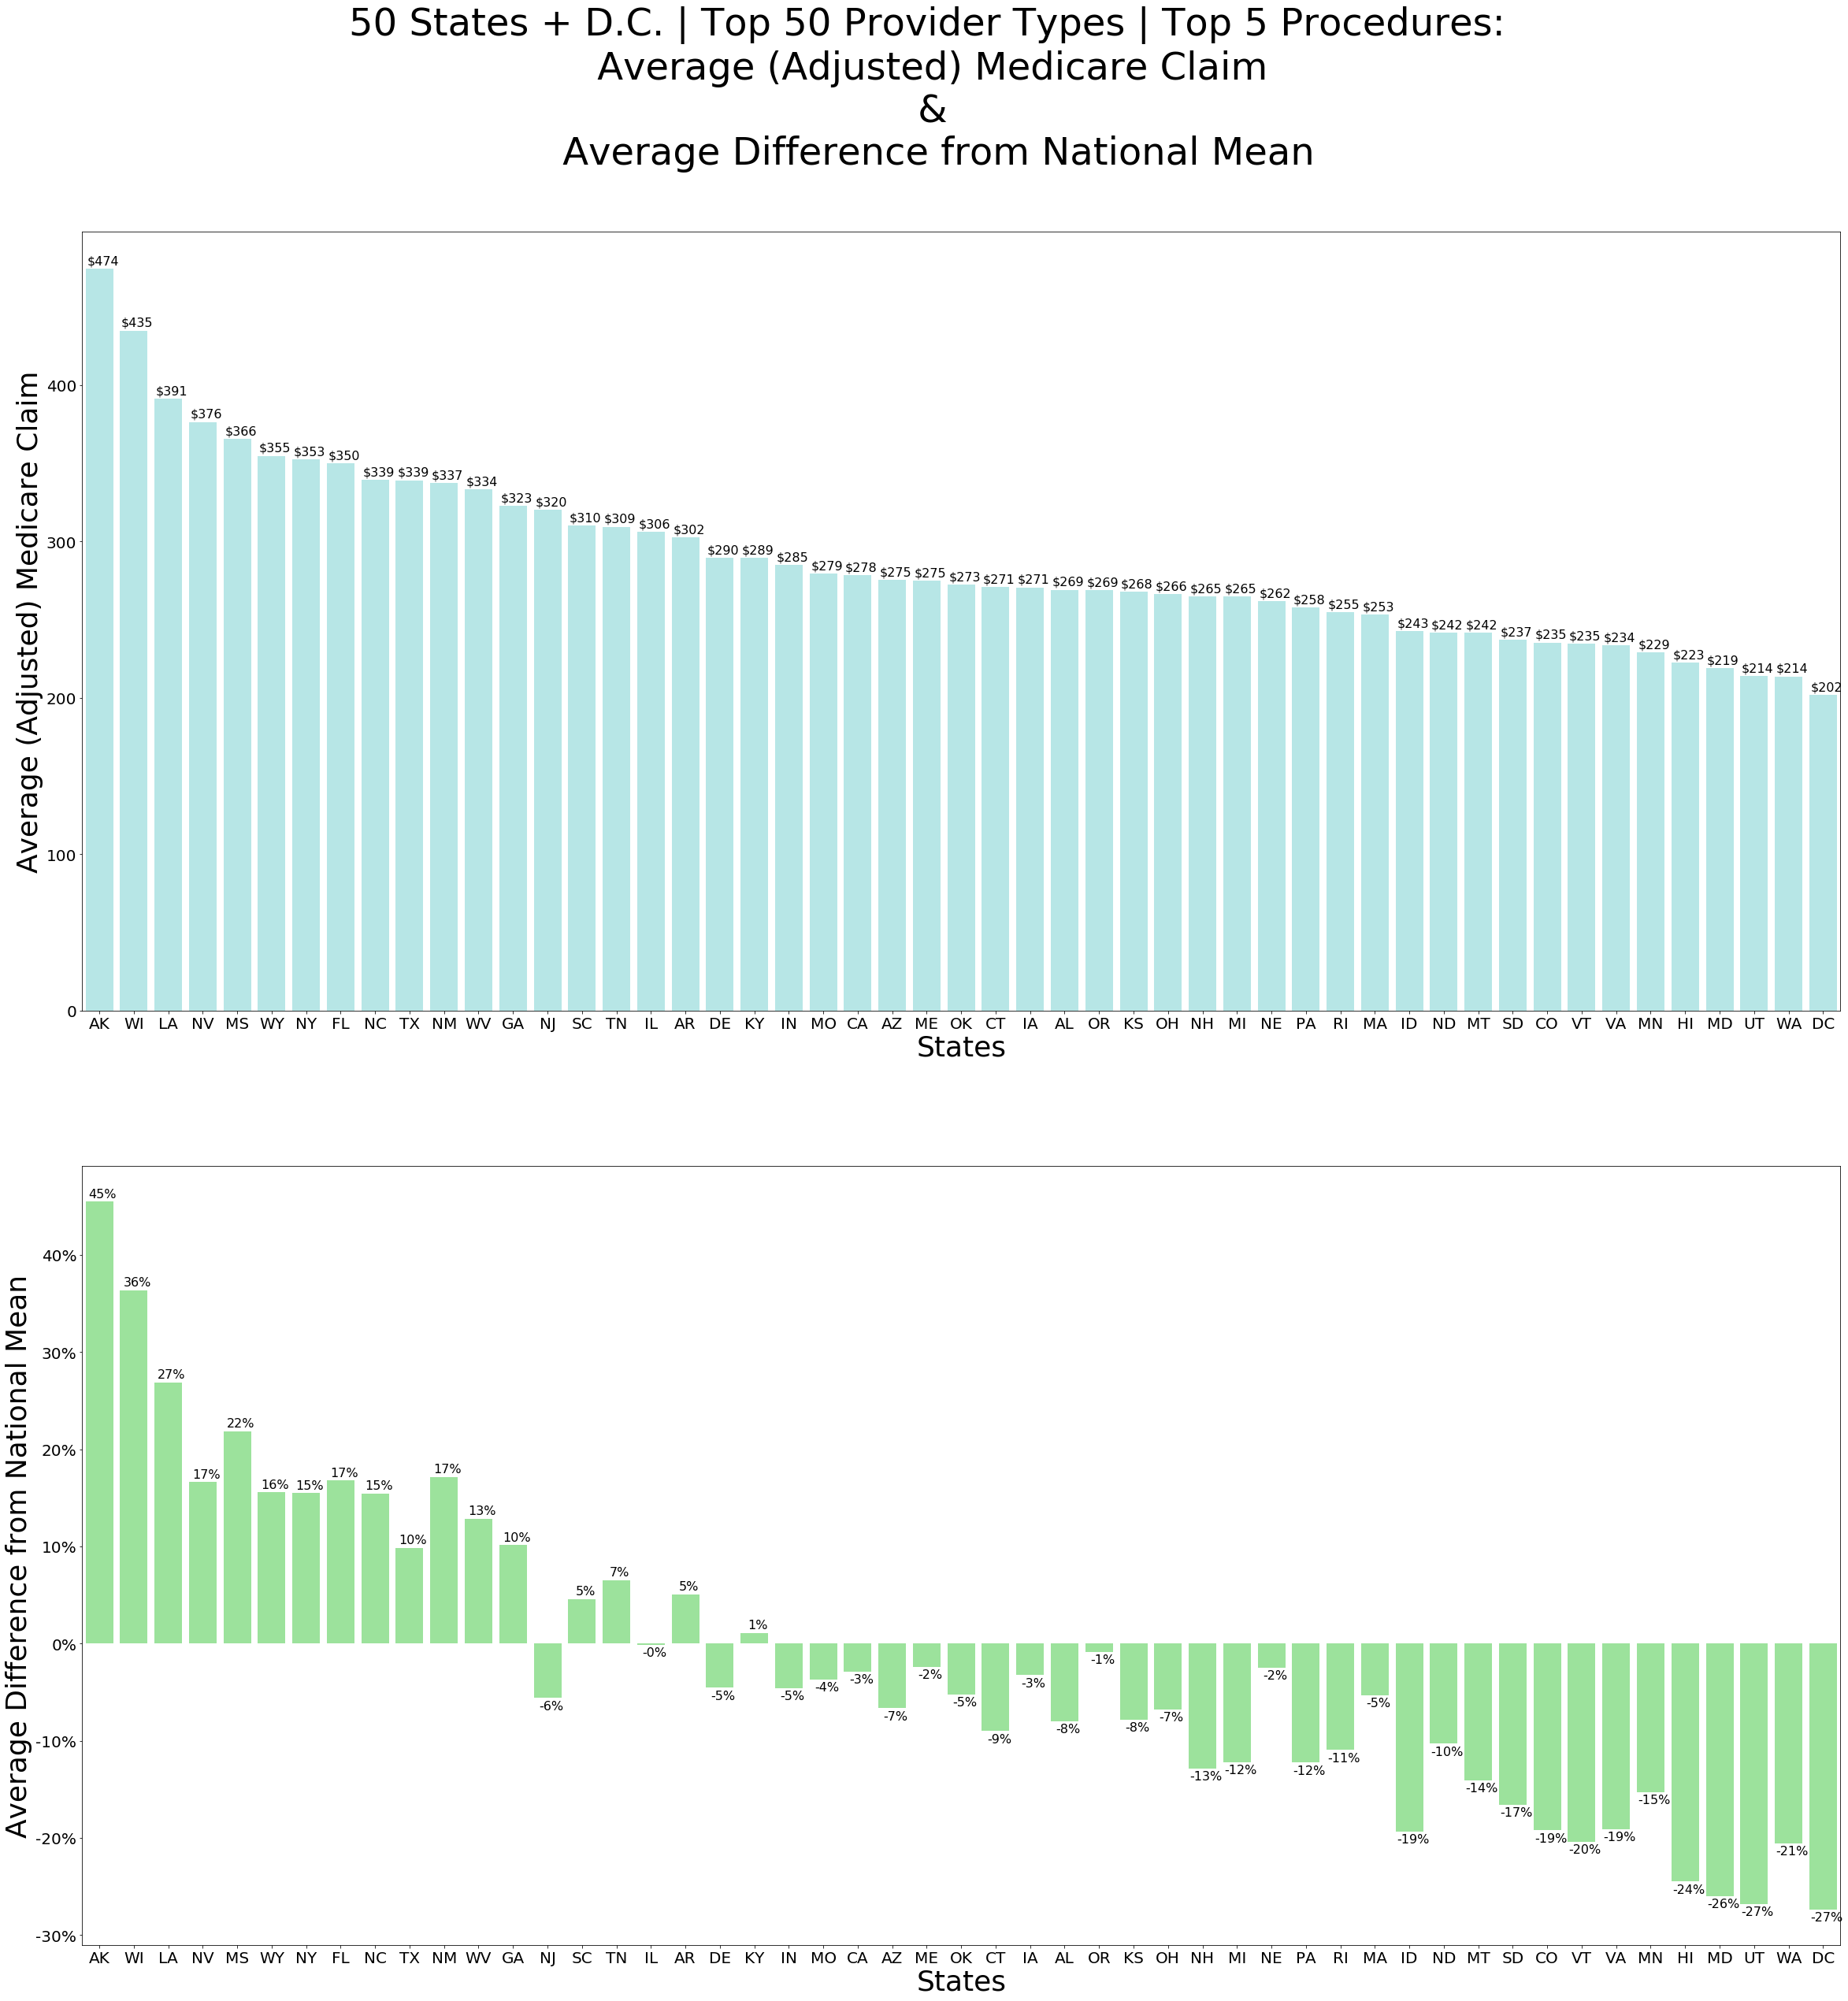

In [333]:
# sort so bar chart is high to low avg price
state_df.sort_values('ADJ_STATE_avg_submitted', ascending=False, inplace=True)

# create combo chart
fig, (ax1, ax2) = plt.subplots(2,figsize=(40,40))
fig.suptitle('50 States + D.C. | Top 50 Provider Types | Top 5 Procedures: \n Average (Adjusted) Medicare Claim \n & \n Average Difference from National Mean', fontsize=48)

# bar plot creation
sns.barplot(x='state', y='ADJ_STATE_avg_submitted', data = state_df, color='paleturquoise', ax=ax1)
ax1.set_ylabel('Average (Adjusted) Medicare Claim', fontsize=36)
ax1.set_xlabel('States', fontsize=36)
ax1.tick_params(axis = 'both', which = 'major', labelsize = 20)

# line plot creation
sns.barplot(x='state', y='ADJ_avg_difference_charged', data = state_df, color='lightgreen', ax=ax2)
ax2.set_ylabel('Average Difference from National Mean', fontsize=36)
ax2.set_xlabel('States', fontsize=36)
ax2.tick_params(axis = 'both', which = 'major', labelsize = 20)
ax2.yaxis.set_major_formatter(PercentFormatter(1))

# IF WE WANT TO ADD DATA LABELS
rects = ax1.patches
# for each bar: Place a label
for rect in rects:
    # get X and Y placement of label from rect.
    x_value = rect.get_x() + 0.5
    y_value = rect.get_height()
    space = 10 # Number of points between bar and label. Change to your liking.
    ha = 'center'

    if y_value < 0: # If value of bar is negative: Place label left of bar
        space *= -1 # Invert space to place label

    # Use X value as label and format number
    label = "${:.0f}".format(y_value)

    # Create annotation
    ax1.annotate(
        label,                      # Use `label` as label
        (x_value, y_value),         # Place label at end of the bar
        xytext=(0, space),          # Horizontally shift label by `space`
        textcoords="offset points", # Interpret `xytext` as offset in points
        va='center',
        ha=ha,                      # Vertically center label
        fontsize=16)                # Horizontally align label differently for
                                    # positive and negative values.

rects2 = ax2.patches
# For each bar: Place a label
for rect in rects2:
    # Get X and Y placement of label from rect.
    x_value = rect.get_x() + 0.5
    y_value = rect.get_height()
    space = 10 # Number of points between bar and label. Change to your liking.
    ha = 'center'

    if y_value < 0: # If value of bar is negative: Place label left of bar
        space *= -1 # Invert space to place label to the left

    # Use X value as label and format number with one decimal place
    label = "{:.0%}".format(y_value)

    # Create annotation
    ax2.annotate(
        label,                      # Use `label` as label
        (x_value, y_value),         # Place label at end of the bar
        xytext=(0, space),          # Horizontally shift label by `space`
        textcoords="offset points", # Interpret `xytext` as offset in points
        va='center',
        ha=ha,                      # Vertically center label
        fontsize=16)                # Horizontally align label differently for
                                    # positive and negative values.

#show plot
plt.show()

#### <font color=orange>C. State Median Price + Mean Diff from National Median  </font>

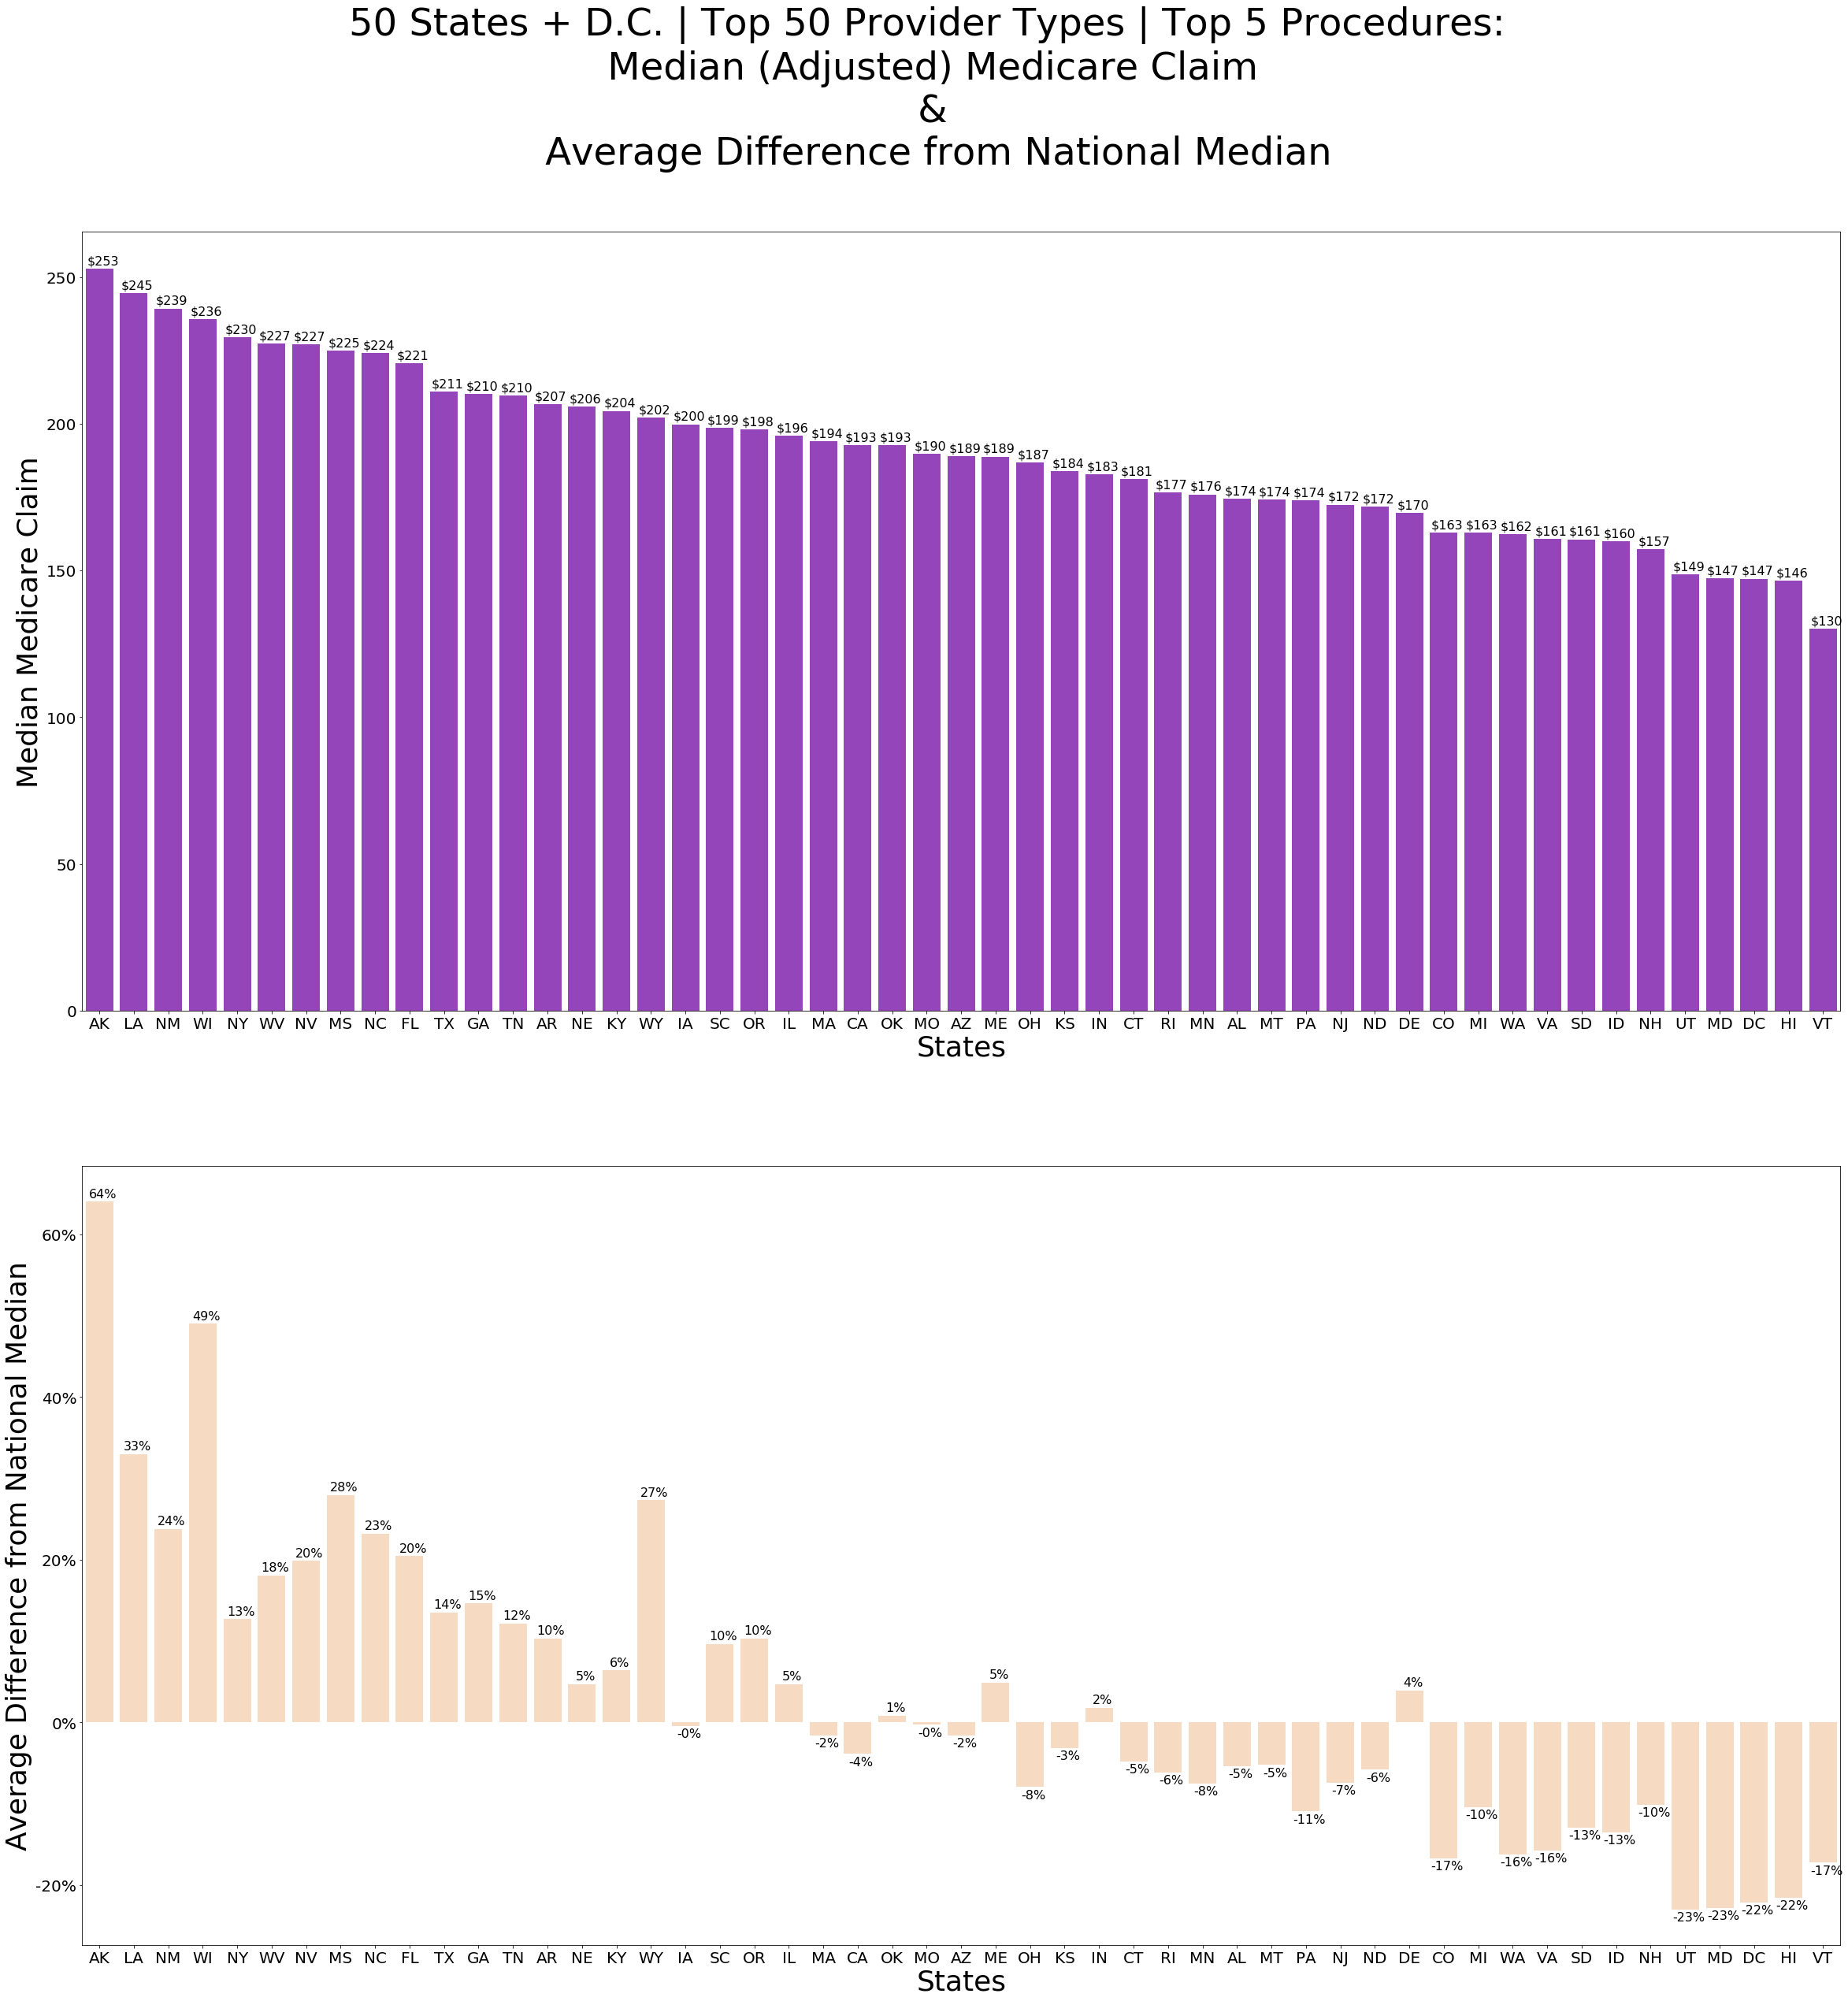

In [334]:
# sort so bar chart is high to low median price
state_df.sort_values('ADJ_STATE_med_submitted', ascending=False, inplace=True)

# Create combo chart
fig, (ax1, ax2) = plt.subplots(2,figsize=(40,40))
fig.suptitle('50 States + D.C. | Top 50 Provider Types | Top 5 Procedures: \n Median (Adjusted) Medicare Claim \n & \n Average Difference from National Median', fontsize=48)

# bar plot creation
sns.barplot(x='state', y='ADJ_STATE_med_submitted', data = state_df, color='darkorchid', ax=ax1)
ax1.set_ylabel('Median Medicare Claim', fontsize=36)
ax1.set_xlabel('States', fontsize=36)
ax1.tick_params(axis = 'both', which = 'major', labelsize = 20)

# line plot creation
sns.barplot(x='state', y='ADJ_med_difference_charged', data = state_df, color='peachpuff', ax=ax2)
ax2.set_ylabel('Average Difference from National Median', fontsize=36)
ax2.set_xlabel('States', fontsize=36)
ax2.tick_params(axis = 'both', which = 'major', labelsize = 20)
ax2.yaxis.set_major_formatter(PercentFormatter(1))


# IF WE WANT TO ADD DATA LABELS

rects = ax1.patches
# For each bar: Place a label
for rect in rects:
    # Get X and Y placement of label from rect.
    x_value = rect.get_x() + 0.5
    y_value = rect.get_height()
    space = 10 # Number of points between bar and label. Change to your liking.

    if y_value < 0: # If value of bar is negative: Place label left of bar
        space *= -1 # Invert space to place label
        ha = 'center' #Horizontal alignment

    # Use X value as label and format number
    label = "${:.0f}".format(y_value)

    # Create annotation
    ax1.annotate(
        label,                      # Use `label` as label
        (x_value, y_value),         # Place label at end of the bar
        xytext=(0, space),          # Horizontally shift label by `space`
        textcoords="offset points", # Interpret `xytext` as offset in points
        va='center',
        ha=ha,                      # Vertically center label
        fontsize=16)                # Horizontally align label differently for
                                    # positive and negative values.

rects2 = ax2.patches
# For each bar: Place a label
for rect in rects2:
    # Get X and Y placement of label from rect.
    x_value = rect.get_x() + 0.5
    y_value = rect.get_height()
    space = 10 # Number of points between bar and label. Change to your liking.

    if y_value < 0: # If value of bar is negative: Place label left of bar
        space *= -1 # Invert space to place label to the left
        ha = 'center' # Horizontally align label at right

    # Use X value as label and format number with one decimal place
    label = "{:.0%}".format(y_value)

    # Create annotation
    ax2.annotate(
        label,                      # Use `label` as label
        (x_value, y_value),         # Place label at end of the bar
        xytext=(0, space),          # Horizontally shift label by `space`
        textcoords="offset points", # Interpret `xytext` as offset in points
        va='center',
        ha=ha,                      # Vertically center label
        fontsize=16)                # Horizontally align label differently for
                                    # positive and negative values.

# show plot
plt.show()

#### <font color=orange>D. Chloropleth Maps: State Mean + Median Claim </font>

In [335]:
# Load the shape of the zone (US states)
# Find the original file here: https://github.com/python-visualization/folium/tree/master/examples/data
# You have to download this file and set the directory where you saved it
state_geo = 'US_States.json'

##### State Mean (Adjusted) Medicare Claim

In [336]:
# Initialize the map:
m = folium.Map(location=[37, -102], zoom_start=3)
 
# Add the color for the chloropleth:
m.choropleth(
 geo_data=state_geo,
 name='choropleth',
 data=state_df,
 columns=['state', 'ADJ_STATE_avg_submitted'],
 key_on='feature.id',
 fill_color='YlGnBu',
 fill_opacity=0.8,
 line_opacity=0.2,
 legend_name='Average (Adjusted) Medicare Claim'
)
    
folium.LayerControl().add_to(m)

m

##### State Median (Adjusted) Medicare Claim

In [337]:
# Initialize the map:
n = folium.Map(location=[37, -102], zoom_start=3)
 
# Add the color for the chloropleth:
n.choropleth(
 geo_data=state_geo,
 name='choropleth',
 data=state_df,
 columns=['state', 'ADJ_STATE_med_submitted'],
 key_on='feature.id',
 fill_color='YlGnBu',
 fill_opacity=0.8,
 line_opacity=0.2,
 legend_name='Median (Adjusted) Medicare Claim'
)
    
folium.LayerControl().add_to(n)

n

### <font color=blue>5. Does Competition Reduce Prices?: Attempt # 1 </font>

Does an increased number of providers offering a service/procedure (hcpcs description) actually result in lower prices for that service/procedure?

In [338]:
# merge the dataframes we created above (but didn't display), which compare state/provider/hcpcs claims vs. national claims
competition_df = pd.merge(avg_comparison_df,
                          med_comparison_df[['state','provider_type','hcpcs_code','med_difference_charged','ADJ_med_difference_charged']],
                          on=['state','provider_type','hcpcs_code'])

competition_df.head()

,state,provider_type,hcpcs_code,STATE_HCPCS_avg_submitted,STATE_HCPCS_med_submitted,ADJ_STATE_HCPCS_avg_submitted,ADJ_STATE_HCPCS_med_submitted,Num Providers,2017 Population,People Per Provider,NAT_avg_submitted,NAT_med_submitted,ADJ_NAT_avg_submitted,ADJ_NAT_med_submitted,avg_difference_charged,ADJ_avg_difference_charged,med_difference_charged,ADJ_med_difference_charged
0,AK,Allergy/ Immunology,95004,15.835184,16.0000,13.454513,13.594551,6,739700,123283.333333,12.619427,11.0,12.403008,11.231609,0.254826,0.084778,0.454545,0.210383
1,AL,Allergy/ Immunology,95004,8.335310,8.0000,10.008294,9.605684,25,4874486,194979.440000,12.619427,11.0,12.403008,11.231609,-0.339486,-0.193075,-0.272727,-0.144763
2,AR,Allergy/ Immunology,95004,11.515530,10.5600,14.473666,13.272678,21,3001345,142921.190476,12.619427,11.0,12.403008,11.231609,-0.087476,0.166948,-0.040000,0.181725
3,AZ,Allergy/ Immunology,95004,9.841357,9.9802,9.881121,10.020526,46,7044008,153130.608696,12.619427,11.0,12.403008,11.231609,-0.220142,-0.203329,-0.092709,-0.107828
4,CA,Allergy/ Immunology,95004,13.491902,11.0000,11.869868,9.677549,228,39358497,172624.986842,12.619427,11.0,12.403008,11.231609,0.069137,-0.042985,0.000000,-0.138365


#### <font color=orange>A. Plot State People per Provider per Service vs. State Claim Diff from National Mean Claim</font>

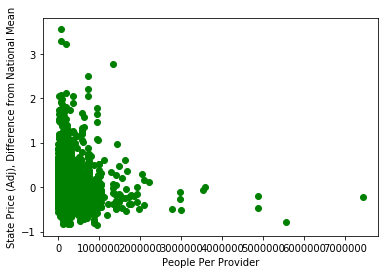

In [339]:
# this is to check if there is an obvious correlation
plt.scatter(competition_df['People Per Provider'],
            competition_df['ADJ_avg_difference_charged'],
            color='green')
plt.xlabel('People Per Provider')
plt.ylabel('State Price (Adj), Difference from National Mean')
plt.show()

#### <font color=orange>B. Plot DIFFERENCE in State People per Provider per Service from National Mean vs. State Claim Diff from National Mean Claim</font>

This is because there was no visible correlation above; this might be due to the fact that  different services ALWAYS have more or less providers, which is clouding the correlation. i.e. maybe there are ALWAYS more physical therapists than occupational therapists.  

Therefore, we should really look at the DIFFERENCE in a state's number of people per provider vs. national mean people per provider for that service.

In [340]:
# calculate national mean people per provider, per hcpcs code
mean_provider = competition_df[['provider_type','hcpcs_code','People Per Provider']].groupby(['provider_type','hcpcs_code'])['People Per Provider'].mean().reset_index()
mean_provider.rename(columns={'People Per Provider': 'NAT Mean People Per Provider'}, inplace=True)

# then add that national mean people per provider to the dataframe we've been using
# also calculate % difference in each state, vs. national mean people per provider
competition_df = pd.merge(competition_df, mean_provider, on=['provider_type','hcpcs_code'])
competition_df['People Per Provider_Diff'] = (competition_df['People Per Provider'] - competition_df['NAT Mean People Per Provider']) / competition_df['NAT Mean People Per Provider']
competition_df.head()

,state,provider_type,hcpcs_code,STATE_HCPCS_avg_submitted,STATE_HCPCS_med_submitted,ADJ_STATE_HCPCS_avg_submitted,ADJ_STATE_HCPCS_med_submitted,Num Providers,2017 Population,People Per Provider,NAT_avg_submitted,NAT_med_submitted,ADJ_NAT_avg_submitted,ADJ_NAT_med_submitted,avg_difference_charged,ADJ_avg_difference_charged,med_difference_charged,ADJ_med_difference_charged,NAT Mean People Per Provider,People Per Provider_Diff
0,AK,Allergy/ Immunology,95004,15.835184,16.0000,13.454513,13.594551,6,739700,123283.333333,12.619427,11.0,12.403008,11.231609,0.254826,0.084778,0.454545,0.210383,156822.435636,-0.213867
1,AL,Allergy/ Immunology,95004,8.335310,8.0000,10.008294,9.605684,25,4874486,194979.440000,12.619427,11.0,12.403008,11.231609,-0.339486,-0.193075,-0.272727,-0.144763,156822.435636,0.243313
2,AR,Allergy/ Immunology,95004,11.515530,10.5600,14.473666,13.272678,21,3001345,142921.190476,12.619427,11.0,12.403008,11.231609,-0.087476,0.166948,-0.040000,0.181725,156822.435636,-0.088643
3,AZ,Allergy/ Immunology,95004,9.841357,9.9802,9.881121,10.020526,46,7044008,153130.608696,12.619427,11.0,12.403008,11.231609,-0.220142,-0.203329,-0.092709,-0.107828,156822.435636,-0.023541
4,CA,Allergy/ Immunology,95004,13.491902,11.0000,11.869868,9.677549,228,39358497,172624.986842,12.619427,11.0,12.403008,11.231609,0.069137,-0.042985,0.000000,-0.138365,156822.435636,0.100767


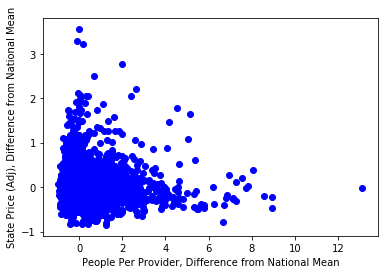

In [341]:
# now plot this new datapoint. Diff in People per Provider vs. national mean, against difference in state mean claim from national mean, adjusted for median income
plt.scatter(competition_df['People Per Provider_Diff'],
            competition_df['ADJ_avg_difference_charged'],
            color='blue')
plt.xlabel('People Per Provider, Difference from National Mean')
plt.ylabel('State Price (Adj), Difference from National Mean')
plt.show()

#### <font color=orange> C. Run Linear Regression </font>

Regress diff in state mean claim per service from national mean, on diff in state people per provider per service from national mean

In [342]:
# now separate data into train and test sets
rand = np.random.rand(len(competition_df)) < 0.8
train = competition_df[rand]
test = competition_df[~rand]
rand

array([ True,  True,  True, ...,  True,  True,  True])

In [343]:
# run regression
from sklearn import linear_model
regr = linear_model.LinearRegression()
train_x = np.asanyarray(train[['People Per Provider_Diff']])
train_y = np.asanyarray(train[['ADJ_avg_difference_charged']])
regr.fit (train_x, train_y)
# The coefficients
print ('Coefficients: ', regr.coef_)
print ('Intercept: ',regr.intercept_)

Coefficients:  [[0.01493075]]
Intercept:  [-0.02069463]


Text(0,0.5,'State Price (Adj), Difference from National Mean')

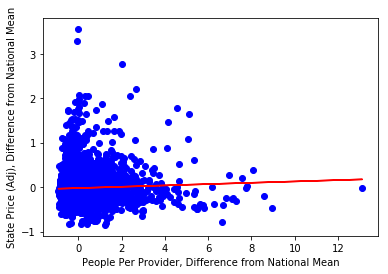

In [344]:
# plot results with regression line
plt.scatter(train[['People Per Provider_Diff']], train[['ADJ_avg_difference_charged']],  color='blue')
plt.plot(train_x, regr.coef_[0][0]*train_x + regr.intercept_[0], '-r')
plt.xlabel('People Per Provider, Difference from National Mean')
plt.ylabel('State Price (Adj), Difference from National Mean')

In [345]:
# now check to see if regression model is accurate (hint: it's not!)
from sklearn.metrics import r2_score

test_x = np.asanyarray(test[['People Per Provider_Diff']])
test_y = np.asanyarray(test[['ADJ_avg_difference_charged']])
test_y_hat = regr.predict(test_x)

print("Mean absolute error: %.2f" % np.mean(np.absolute(test_y_hat - test_y)))
print("Residual sum of squares (MSE): %.2f" % np.mean((test_y_hat - test_y) ** 2))
print("R2-score: %.2f" % r2_score(test_y_hat , test_y) )

Mean absolute error: 0.17
Residual sum of squares (MSE): 0.06
R2-score: -736.78


So we see there is no evidence that an increase in number of providers offering a service yields a lower price for that service. The R2 score demonstrates that this linear model does not explain the data well. However, there are likely MANY factors that affect medical pricing differences, especially differences between states.  

We do see that the coefficient is directionally what we would expect. As the number of people per provider increases, the price increases. But these results are really not useful.

### <font color=blue>6. How have prices changed over time?</font>

Import 2012 Medicare Provider Utilization and Payment Data at:  
https://data.cms.gov/Medicare-Physician-Supplier/Medicare-Provider-Utilization-and-Payment-Data-Phy/jzd2-pt4g  

This way we can do a 5 year comparison of submitted claims

#### <font color=orange>A. Medicare 2012 Claims Data: Import and Clean</font>

In [346]:
# import 2012 dataset
df_2012 = pd.read_csv("Medicare_Provider_Utilization_and_Payment_Data__Physician_and_Other_Supplier_CY2012.csv")
df_2012.head()

C:\Users\abode\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,National Provider Identifier,Last Name/Organization Name,First Name,Middle Initial,Credentials,Gender,Entity Code,Street Address 1,Street Address 2,City,...,HCPCS Drug Indicator,Number of Services,Number of Medicare Beneficiaries,Number of Medicare Beneficiary/Day Services,Average Medicare Allowed Amount,Standard Deviation of Medicare Allowed Amount,Average Submitted Charge Amount,Standard Deviation of Submitted Charge Amount,Average Medicare Payment Amount,Standard Deviation of Medicare Payment Amount
0,1184612244,BRAHNEY,JODY,S,MD,M,I,5301 VIRGINIA WAY,SUITE 300,BRENTWOOD,...,N,153.0,78,80,57.020000,0.000000,152.700719,4.031577,44.613268,5.078601
1,1699720995,GRENZ,DONALD,H,MD,M,I,401 N 9TH ST,NaN,BISMARCK,...,N,85.0,75,85,11.470000,0.000000,36.000000,0.000000,11.392000,0.714882
2,1871566638,INDES,JODI,E,M.D.,F,I,5 DURHAM RD,"BUILDING 3, SUITE C1",GUILFORD,...,N,16.0,16,16,178.150000,0.000000,298.125000,87.640512,178.150000,0.000000
3,1972581403,SALAMA,SHERIF,A,MD,M,I,850 BRAINARD RD,NaN,HIGHLAND HTS,...,N,33.0,25,33,206.696061,34.445926,1093.939394,340.622775,143.307273,52.987734
4,1679543235,AHARON,RAPHAEL,NaN,MD,M,I,10837 71ST AVE,NaN,FOREST HILLS,...,N,13.0,12,13,407.861538,68.891400,437.055385,137.325963,317.124615,65.860982


In [347]:
# clean up dataframe and rename columns/provider types so that they match the 2017 dataframe

# drop unneccesary columns as well as non-US providers
df2_2012 = df_2012.drop(['Middle Initial',
               'Credentials',
               'Entity Code',
               'Street Address 1',
               'Street Address 2',
               'Medicare Participation',
               'Number of Services',
               'Number of Medicare Beneficiaries',
               'Number of Medicare Beneficiary/Day Services'
              ], axis=1)
df2_2012.drop(df2_2012.loc[df2_2012['Country Code'] != 'US'].index, inplace=True)
df2_2012.dropna(inplace=True)

# drop the armed forces and territories
Non_States = ['VI','GU','ZZ','AE','AP','MP','XX','AA','AS','PR']
df2_2012 = df2_2012[~df2_2012['State Code'].isin(Non_States)]

# remove provider types that provide no billable services in dataset
No_Services = ['Mass Immunizer Roster Biller', 'Clinical Laboratory', 'Ambulatory Surgical Center', 'Centralized Flu']
df2_2012 = df2_2012[~df2_2012['Provider Type'].isin(No_Services)]

# rename columns
df2_2012.rename(columns={"State Code": "state"}, inplace=True)
df2_2012.rename(columns={"HCPCS Description": "hcpcs_description"}, inplace=True)
df2_2012.rename(columns={"HCPCS Code": "hcpcs_code"}, inplace=True)
df2_2012.rename(columns={"Average Submitted Charge Amount": "average_submitted_chrg_amt"}, inplace=True)
df2_2012.rename(columns={"Provider Type": "provider_type"}, inplace=True)

# rename provider types, which changed nomenclature between 2012 and 2017
df2_2012.replace('Physical Therapist', 'Physical Therapist in Private Practice',inplace=True)
df2_2012.replace('Occupational therapist', 'Occupational Therapist in Private Practice',inplace=True)
df2_2012.replace('Obstetrics/Gynecology', 'Obstetrics & Gynecology',inplace=True)
df2_2012.replace('Hematology/Oncology', 'Hematology-Oncology',inplace=True)
df2_2012.replace('Clinical Psychologist', 'Psychologist, Clinical',inplace=True)
df2_2012.replace('Cardiac Electrophysiology', 'Clinical Cardiac Electrophysiology',inplace=True)
df2_2012.replace('Audiologist (billing independently)', 'Audiologist',inplace=True)
df2_2012.replace('Allergy/Immunology', 'Allergy/ Immunology',inplace=True)

# reduce table down to just include the 50 most common provider types in 2017
df2_2012 = df2_2012[df2_2012['provider_type'].isin(providerlist)]

df2_2012.head()

,National Provider Identifier,Last Name/Organization Name,First Name,Gender,City,Zip Code,state,Country Code,provider_type,Place of Service,hcpcs_code,hcpcs_description,HCPCS Drug Indicator,Average Medicare Allowed Amount,Standard Deviation of Medicare Allowed Amount,average_submitted_chrg_amt,Standard Deviation of Submitted Charge Amount,Average Medicare Payment Amount,Standard Deviation of Medicare Payment Amount
0,1184612244,BRAHNEY,JODY,M,BRENTWOOD,370277541,TN,US,Pathology,F,88331,Pathology examination of tissue during surgery,N,57.020000,0.000000,152.700719,4.031577,44.613268,5.078601
1,1699720995,GRENZ,DONALD,M,BISMARCK,585014507,ND,US,Internal Medicine,O,84439,Thyroxine (thyroid chemical) measurement,N,11.470000,0.000000,36.000000,0.000000,11.392000,0.714882
2,1871566638,INDES,JODI,F,GUILFORD,64372076,CT,US,Internal Medicine,O,G0438,Annual wellness visit; includes a personalized...,N,178.150000,0.000000,298.125000,87.640512,178.150000,0.000000
3,1972581403,SALAMA,SHERIF,M,HIGHLAND HTS,441433146,OH,US,Interventional Pain Management,O,64490,Injection of upper or middle spine facet joint...,N,206.696061,34.445926,1093.939394,340.622775,143.307273,52.987734
4,1679543235,AHARON,RAPHAEL,M,FOREST HILLS,113754566,NY,US,Ophthalmology,O,66821,Removal of recurring cataract in lens capsule ...,N,407.861538,68.891400,437.055385,137.325963,317.124615,65.860982


#### <font color=orange>B. 2017 State Population Data: Import and Clean</font>
Data obtained from US Census: https://www.census.gov/data/tables/time-series/demo/popest/2010s-state-total.html

In [348]:
# import data from CSV (copy/pasted with Medicare column titles)
population_df_2012 = pd.read_csv("2012 US Population.csv")
population_df_2012.head()

,state,2012 Population
0,US,313830990
1,AL,4815588
2,AK,730443
3,AZ,6554978
4,AR,2952164


#### <font color = orange>C. Calculating the Mean & Median Medicare Claims (like we did for 2017; unadjusted)</font>

We now calculate the Mean and Median medicare claims submitted by:  
A. Provider & HCPCS (Procedure) Description (i.e. Cardiologist Heart Transplant mean cost is 10,000 dollars)  
B. State & Provider & HCPCS (Procedure) Description (i.e. Cardiologist Heart Transplant in New York mean cost is 15,000 dollars)  
C. State (i.e. New York mean procedure cost is 300 dollars)  

Note that our state mean/median is based off of the means/medians calculated in item #2 on the list, so that each procedure and each provider is equally weighted in the calculation


In [349]:
# create dataframe with just state, provider type, hcpcs description, and average submitted charge for that hcpcs description
hcpcs_df_2012 = df2_2012[['state','provider_type','hcpcs_code','hcpcs_description','average_submitted_chrg_amt']]

hcpcs_df_2012.head()

,state,provider_type,hcpcs_code,hcpcs_description,average_submitted_chrg_amt
0,TN,Pathology,88331,Pathology examination of tissue during surgery,152.700719
1,ND,Internal Medicine,84439,Thyroxine (thyroid chemical) measurement,36.000000
2,CT,Internal Medicine,G0438,Annual wellness visit; includes a personalized...,298.125000
3,OH,Interventional Pain Management,64490,Injection of upper or middle spine facet joint...,1093.939394
4,NY,Ophthalmology,66821,Removal of recurring cataract in lens capsule ...,437.055385


##### 2012 NATIONAL HCPCS MEAN & MEDIAN

In [350]:
# take unadj. average by hcpcs description & provider
hcpcs_df_avg_2012 = hcpcs_df_2012[['provider_type','hcpcs_code','average_submitted_chrg_amt']].groupby(['provider_type','hcpcs_code']).mean()
hcpcs_df_avg_2012.rename(columns={"average_submitted_chrg_amt": "2012_NAT_avg_submitted"},
                    inplace=True)

# take unadj. median by hcpcs description & provider
hcpcs_df_med_2012 = hcpcs_df_2012[['provider_type','hcpcs_code','average_submitted_chrg_amt']].groupby(['provider_type','hcpcs_code']).median()
hcpcs_df_med_2012.rename(columns={"average_submitted_chrg_amt": "2012_NAT_med_submitted"},
                    inplace=True)

# merge dataframes and flatten table out
nat_hcpcs_df_2012 = pd.merge(hcpcs_df_avg_2012, hcpcs_df_med_2012, on=['provider_type','hcpcs_code'])
nat_hcpcs_df_2012.reset_index(inplace=True)

# merge with 2017 NATIONAL HCPCS MEAN & MEDIAN to perform comparisons
nat_hcpcs_df_2012 = pd.merge(nat_hcpcs_df,
                             nat_hcpcs_df_2012,
                             how='left',
                             on=['provider_type', 'hcpcs_code'])

nat_hcpcs_df_2012.dropna(inplace=True)
nat_hcpcs_df_2012.rename(columns={"NAT_avg_submitted":"2017_NAT_avg_submitted"},inplace=True)
nat_hcpcs_df_2012.rename(columns={"NAT_med_submitted":"2017_NAT_med_submitted"},inplace=True)
nat_hcpcs_df_2012.rename(columns={"ADJ_NAT_avg_submitted":"2017_ADJ_NAT_avg_submitted"},inplace=True)
nat_hcpcs_df_2012.rename(columns={"ADJ_NAT_med_submitted":"2017_ADJ_NAT_med_submitted"},inplace=True)

nat_hcpcs_df_2012['5 Yr Change'] = nat_hcpcs_df_2012['2017_NAT_avg_submitted']/nat_hcpcs_df_2012['2012_NAT_avg_submitted']-1

nat_hcpcs_df_2012.head()

,provider_type,hcpcs_code,2017_NAT_avg_submitted,2017_NAT_med_submitted,2017_ADJ_NAT_avg_submitted,2017_ADJ_NAT_med_submitted,2012_NAT_avg_submitted,2012_NAT_med_submitted,5 Yr Change
0,Allergy/ Immunology,95004,12.619427,11.000000,12.403008,11.231609,10.460941,9.111998,0.206338
1,Allergy/ Immunology,95117,33.692280,32.000000,33.276428,32.296507,32.860720,30.083333,0.025306
2,Allergy/ Immunology,99204,288.425813,260.000000,284.166826,259.812830,250.582630,230.000000,0.151021
3,Allergy/ Immunology,99213,124.571406,113.858077,122.669402,114.326241,105.041373,95.000000,0.185927
4,Allergy/ Immunology,99214,184.616495,165.000000,180.732863,165.605532,156.637519,143.049296,0.178622


##### 2012 STATE HCPCS MEAN & MEDIAN

Include number of providers per state per HCPCS, and add population to calculate number of people per provider

In [351]:
# take unadj. average by state & hcpcs description & provider
state_hcpcs_df_avg_2012 = hcpcs_df_2012[['state','provider_type','hcpcs_code','average_submitted_chrg_amt']].groupby(['state','provider_type','hcpcs_code']).mean()
state_hcpcs_df_avg_2012.rename(columns={"average_submitted_chrg_amt": "2012_STATE_HCPCS_avg_submitted"},
                  inplace=True)

# take unadj. median by state & hcpcs description & provider
state_hcpcs_df_med_2012 = hcpcs_df_2012[['state','provider_type','hcpcs_code','average_submitted_chrg_amt']].groupby(['state','provider_type','hcpcs_code']).median()
state_hcpcs_df_med_2012.rename(columns={"average_submitted_chrg_amt": "2012_STATE_HCPCS_med_submitted"},
                  inplace=True)

# merge dataframes and flatten table out
state_hcpcs_df_2012 = pd.merge(state_hcpcs_df_avg_2012, state_hcpcs_df_med_2012, on=['state','provider_type','hcpcs_code'])
state_hcpcs_df_2012.reset_index(inplace=True)

In [352]:
# pull just provider ID, state, type, and hcpcs description to find out how many providers offer a procedure/service in a given state
prov_per_state_2012 = df2_2012[['National Provider Identifier','state', 'provider_type', 'hcpcs_code']].drop_duplicates()
prov_per_state_2012 = prov_per_state_2012.groupby(['state','provider_type','hcpcs_code']).count()
prov_per_state_2012.reset_index(inplace=True)
prov_per_state_2012.rename(columns={'National Provider Identifier':'2012 Num Providers'},inplace=True)

# add number of providers to the dataframe
state_hcpcs_df_2012 = pd.merge(state_hcpcs_df_2012,
                               prov_per_state_2012,
                               on=['state','provider_type','hcpcs_code'])

In [353]:
# add state population to the dataframe
state_hcpcs_df_2012 = pd.merge(state_hcpcs_df_2012,
                               population_df_2012,
                               on=['state'])

# calculate people per provider per procedure/service (hcpcs description)
state_hcpcs_df_2012['2012 People Per Provider'] = state_hcpcs_df_2012['2012 Population'] / state_hcpcs_df_2012['2012 Num Providers']

In [354]:
# merge with 2017 STATE HCPCS MEAN & MEDIAN table to perform comparisons
# note we perform a left merge so that there is a match in provider type and HCPCS code between 2012 and 2017
state_hcpcs_df_2012 = pd.merge(state_hcpcs_df,
                               state_hcpcs_df_2012,
                               how='left',
                               on=['state', 'provider_type', 'hcpcs_code'])

state_hcpcs_df_2012.dropna(inplace=True)
state_hcpcs_df_2012.rename(columns={"STATE_HCPCS_avg_submitted":"2017_STATE_HCPCS_avg_submitted"},inplace=True)

# calculate 5 yr change in mean claim submitted; also calculate change in people per provider offering service
# comparisons are between 2017 and 2012
state_hcpcs_df_2012['5 Yr Change'] = state_hcpcs_df_2012['2017_STATE_HCPCS_avg_submitted']/state_hcpcs_df_2012['2012_STATE_HCPCS_avg_submitted']-1
state_hcpcs_df_2012['Change in Ppl per Provider'] = state_hcpcs_df_2012['People Per Provider']/state_hcpcs_df_2012['2012 People Per Provider']-1

state_hcpcs_df_2012.head()

,state,provider_type,hcpcs_code,2017_STATE_HCPCS_avg_submitted,STATE_HCPCS_med_submitted,ADJ_STATE_HCPCS_avg_submitted,ADJ_STATE_HCPCS_med_submitted,Num Providers,2017 Population,People Per Provider,2012_STATE_HCPCS_avg_submitted,2012_STATE_HCPCS_med_submitted,2012 Num Providers,2012 Population,2012 People Per Provider,5 Yr Change,Change in Ppl per Provider
0,AK,Allergy/ Immunology,95004,15.835184,16.000000,13.454513,13.594551,6,739700,123283.333333,13.131581,13.131581,2.0,730443.0,365221.50,0.205886,-0.662442
2,AK,Allergy/ Immunology,99204,411.370879,407.000000,349.525144,345.811385,6,739700,123283.333333,373.933333,373.933333,2.0,730443.0,365221.50,0.100118,-0.662442
3,AK,Allergy/ Immunology,99213,185.469867,180.000000,157.586220,152.938696,8,739700,92462.500000,166.434783,166.434783,1.0,730443.0,730443.00,0.114370,-0.873416
4,AK,Allergy/ Immunology,99214,271.335714,265.000000,230.542946,225.159747,7,739700,105671.428571,221.267923,221.276596,3.0,730443.0,243481.00,0.226277,-0.565997
5,AK,Anesthesiology,00142,972.239962,956.637931,826.072845,812.816432,16,739700,46231.250000,736.941201,857.109333,25.0,730443.0,29217.72,0.319291,0.582302


In [355]:
state_hcpcs_df_2012.isnull().values.sum()

0

##### 2012 STATE MEAN & MEDIAN

In [356]:
# reduce the STATE HCPCS dataframe down to just the categories we need: state, 2017 mean claim, 2012 mean claim
state_df_2012 = state_hcpcs_df_2012[['state',
                                     '2017_STATE_HCPCS_avg_submitted',
                                     '2012_STATE_HCPCS_avg_submitted']]

# group by state and calculate the mean (this reduces the table down so instead of one row per HCPCS per state, it is now one row per state)
state_df_2012 = state_df_2012.groupby(['state']).mean()
state_df_2012.rename(columns={'2017_STATE_HCPCS_avg_submitted':'2017_STATE_avg_submitted',
                              '2012_STATE_HCPCS_avg_submitted':'2012_STATE_avg_submitted'},
                     inplace=True)

# calculate the 5 yr change
state_df_2012['5 Yr Change'] = (state_df_2012['2017_STATE_avg_submitted']/state_df_2012['2012_STATE_avg_submitted']-1)
state_df_2012.reset_index(inplace=True)
state_df_2012.head()

,state,2017_STATE_avg_submitted,2012_STATE_avg_submitted,5 Yr Change
0,AK,514.404760,390.031652,0.318880
1,AL,210.516951,188.092330,0.119221
2,AR,227.148641,199.998796,0.135750
3,AZ,261.189054,222.249221,0.175208
4,CA,296.733209,245.765949,0.207381


In [357]:
# visualize 5 yr change in a color gradient table
state_df_2012_change = state_df_2012.copy()

state_df_2012_change.sort_values('5 Yr Change', ascending = False, inplace=True)
state_df_2012_change['2017_STATE_avg_submitted'] = state_df_2012_change['2017_STATE_avg_submitted'].round(2)
state_df_2012_change['2012_STATE_avg_submitted'] = state_df_2012_change['2012_STATE_avg_submitted'].round(2)
state_df_2012_change['5 Yr Change'] = (state_df_2012_change['5 Yr Change'] * 100).round(2)

state_df_2012_change.set_index('state', inplace=True)

cm = sns.diverging_palette(240, 10, n=9, as_cmap=True) 
state_df_2012_change.style.background_gradient(cmap=cm)

,2017_STATE_avg_submitted,2012_STATE_avg_submitted,5 Yr Change
state,,,
WY,318.15,237.19,34.13
AK,514.4,390.03,31.89
NV,342.5,266.25,28.64
NY,350.56,286.21,22.48
WI,433.21,354.12,22.33
NJ,376.94,308.59,22.15
CA,296.73,245.77,20.74
TX,302.61,254.45,18.93
GA,287.34,244.21,17.66


#### <font color=orange>D. Chloropleth Map: 5 Yr Change in Mean Medicare Claim, by State 

In [358]:
# Initialize the map:
o = folium.Map(location=[37, -102], zoom_start=3)
 
# Add the color for the chloropleth:
o.choropleth(
 geo_data=state_geo,
 name='choropleth',
 data=state_df_fin_comp,
 columns=['state', '5 Yr Change'],
 key_on='feature.id',
 fill_color='YlGnBu',
 fill_opacity=0.8,
 line_opacity=0.2,
 legend_name='Avg. 5 Yr Change: Medicare Claims'
)
    
folium.LayerControl().add_to(o)

o

#### <font color=orange> E. Rates of change

In [359]:
mean_5yr_hcpcs_change = "{:.2%}".format(nat_hcpcs_df_2012['5 Yr Change'].mean())
mean_5yr_state_change = "{:.2%}".format(state_df_2012['5 Yr Change'].mean())

print("National avg. 5 yr change in submitted claim per service was: " + mean_5yr_hcpcs_change)
print("----------------------------------------------------------------------------------------------")
print("Avg. 5 yr change in submitted claim per state was: " + mean_5yr_state_change)

National avg. 5 yr change in submitted claim per service was: 16.01%
----------------------------------------------------------------------------------------------
Avg. 5 yr change in submitted claim per state was: 14.45%


### <font color=blue>7. Does Competition Reduce Prices?: Attempt # 2 </font>

There are likely MANY factors responsible for differences in medical prices across state lines. Therefore, to eliminate noise we will perform one more attempt to see whether more doctors providing a service means lower prices for that service.  

We will do this by performing an intra-state analysis, which means we will look at the five year change in people per provider per service state, and change in price per service per state.  

The idea is that, if all of a sudden between 2012 and 2017 in New York there was a flood of new Physical Therapists, would this also result in Physical Therapy services falling in price? etc. Hopefully since this is looking at the same state 5 years apart, some of that additional noise that we had in our interstate analysis will be removed.

#### <font color=orange>A. Plot Change in People per Provider per Service vs. Change in Submitted Claim per Service per State</font>

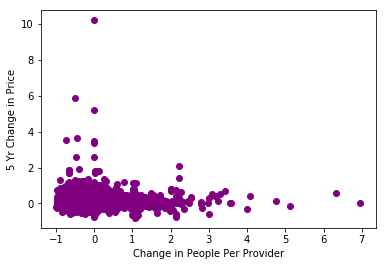

In [360]:
# this is to visualize if there is an obvious correlation
plt.scatter(state_hcpcs_df_2012['Change in Ppl per Provider'],
            state_hcpcs_df_2012['5 Yr Change'],
            color='purple')
plt.xlabel('Change in People Per Provider')
plt.ylabel('5 Yr Change in Price')
plt.show()

#### <font color=orange> B. Run Linear Regression </font>

Regress change in price per service per state on change in people per provider per service per state

In [361]:
# divide data into training and testing sets
rand = np.random.rand(len(state_hcpcs_df_2012)) < 0.8
train = state_hcpcs_df_2012[rand]
test = state_hcpcs_df_2012[~rand]

# run regression
regr = linear_model.LinearRegression()
train_x = np.asanyarray(train[['Change in Ppl per Provider']])
train_y = np.asanyarray(train[['5 Yr Change']])
regr.fit (train_x, train_y)

# the coefficients
print ('Coefficients: ', regr.coef_)
print ('Intercept: ', regr.intercept_)

Coefficients:  [[-0.02951006]]
Intercept:  [0.15130263]


Text(0,0.5,'5 Yr Change in Price')

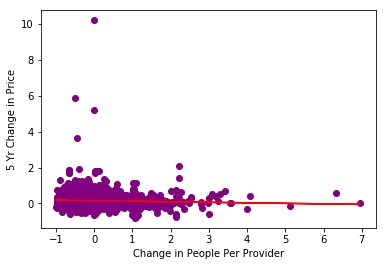

In [362]:
# plot regression line
plt.scatter(train[['Change in Ppl per Provider']], train[['5 Yr Change']],  color='purple')
plt.plot(train_x, regr.coef_[0][0]*train_x + regr.intercept_[0], '-r')
plt.xlabel('Change in People Per Provider')
plt.ylabel('5 Yr Change in Price')

In [363]:
# check to see the accurace of the linear regression model
test_x = np.asanyarray(test[['Change in Ppl per Provider']])
test_y = np.asanyarray(test[['5 Yr Change']])
test_y_hat = regr.predict(test_x)

print("Mean absolute error: %.2f" % np.mean(np.absolute(test_y_hat - test_y)))
print("Residual sum of squares (MSE): %.2f" % np.mean((test_y_hat - test_y) ** 2))
print("R2-score: %.2f" % r2_score(test_y_hat , test_y) )

Mean absolute error: 0.13
Residual sum of squares (MSE): 0.05
R2-score: -474.03


Again, we see that our simple linear regression model cannot explain the data, even when we are comparing intra-state instead of inter-state.  

So while definitely not conclusive evidence, increasing "competition" (aka more doctors providing a service) does not obviously result in lower prices for that service. Further analyses should incorporate additional factors which may be contributing to changes in medical prices. But with this simple analysis, we cannot say that more competition means lower prices.